In [311]:
from __future__ import annotations

import pandas as pd
import numpy.typing as npt
import math
from collections.abc import Sequence
from dataclasses import dataclass
import graphviz as gv

In [312]:
def entropy(value_count: npt.ArrayLike) -> float:
    """Calculate the entropy of the given value counts."""
    if 0 in value_count:
        return 0
    e = 0.0
    total = sum(value_count)
    for vc in value_count:
        e -= vc / total * math.log2(vc / total)
    return e

In [313]:
def gain(df: pd.DataFrame, attr: str, target: str) -> float:
    """Calculate the gain of selecting the specified attribute"""
    s = df[target].value_counts()
    g = entropy(s.array)
    sv = df[attr].value_counts()
    for at in sv.index:
        g -= sv[at] / len(df) * entropy(df[df[attr] == at][target].value_counts().array) 
    return g

In [314]:
@dataclass
class Node:
    """A node in the decision tree"""
    label: str
    children: dict[str, Node] | None

    @property
    def is_leaf(self):
        return self.children == None
    
    def make_decision(self, attrs: dict[str, str]):
        if self.is_leaf:
            return self.label
        elif self.label in attrs.keys():
            value = attrs[self.label]
            return self.children[value].make_decision(attrs)
        else:
            raise ValueError(f"{self.label} doesn't exist in `attrs`")

In [315]:
def id3(df: pd.DataFrame, target: str, attrs: Sequence[str]) -> Node:
    """The ID3 algorithm for training decision trees"""
    if df[target].nunique() == 1:
        root = Node(df[target].iloc[0], None)
    elif len(attrs) == 0:
        root = Node(df[target].value_counts().sort_values(ascending=False).index[0], None)
    else:
        gains = pd.Series({k: v for k, v in zip(attrs, [gain(df, attr, target) for attr in attrs])})
        best_attr = gains.sort_values(ascending=False).index[0]
        root = Node(best_attr, {})
        for value in sorted(df[best_attr].unique()):
            dfi: pd.DataFrame = df[df[best_attr] == value]
            if dfi.empty:
                root.children[value] = Node(df[target].value_counts().sort_values(ascending=False).index[0], None)
            else:
                root.children[value] = id3(dfi, target, [a for a in attrs if a != best_attr])
    return root

In [316]:
# Read and show training data
df = pd.read_csv("../data/playtennis.csv")

df

,Day,Outlook,Temperature,Humidity,Wind,Play Tennis
0,1,Sunny,Hot,High,Weak,No
1,2,Sunny,Hot,High,Strong,No
2,3,Overcast,Hot,High,Weak,Yes
3,4,Rain,Mild,High,Weak,Yes
4,5,Rain,Cool,Normal,Weak,Yes
5,6,Rain,Cool,Normal,Strong,No
6,7,Overcast,Cool,Normal,Strong,Yes
7,8,Sunny,Mild,High,Weak,No
8,9,Sunny,Cool,Normal,Weak,Yes
9,10,Rain,Mild,Normal,Weak,Yes


In [317]:
# Build decision tree using the ID3 algorithm
root = id3(df, "Play Tennis", ("Outlook", "Temperature", "Humidity", "Wind"))

root

Node(label='Outlook', children={'Overcast': Node(label='Yes', children=None), 'Rain': Node(label='Wind', children={'Strong': Node(label='No', children=None), 'Weak': Node(label='Yes', children=None)}), 'Sunny': Node(label='Humidity', children={'High': Node(label='No', children=None), 'Normal': Node(label='Yes', children=None)})})

In [318]:
# Make a decision given specific conditions
root.make_decision({'Outlook':'Sunny', 'Temperature': 'Hot', 'Humidity': 'Normal', 'Wind': 'Weak'})

'Yes'

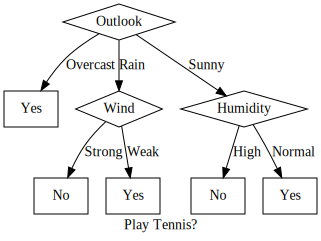

In [319]:
# Code for plotting the decision tree using graphviz

class Counter:
    """Helper class to avoid single leaf labels"""
    def __init__(self):
        self._i = 0
    @property
    def next(self) -> int:
        self._i += 1
        return self._i

def add_children(gvtree: gv.Digraph, node: Node, counter: Counter) -> None:
    """Add children to the specified node"""
    for attr, child_node in node.children.items():
        if child_node.is_leaf:
            gvtree.attr('node', shape='box')
            node_id = f"{child_node.label}_{counter.next}"
            gvtree.node(node_id, label=child_node.label)
            gvtree.edge(node.label, node_id, label=attr) 
        else:
            gvtree.attr('node', shape='diamond')
            gvtree.node(child_node.label)
            gvtree.edge(node.label, child_node.label, label=attr)
            add_children(gvtree, child_node, counter)

def create_gvtree(root: Node) -> gv.Digraph:
    """Create a GraphViz digraph given the root of the decision tree"""
    gvtree = gv.Digraph(graph_attr = {'label': 'Play Tennis?'})
    if root.is_leaf:
        gvtree.attr('node', shape='box')
        gvtree.node(root.label)
    else:
        gvtree.attr('node', shape='diamond')
        gvtree.node(root.label)
        add_children(gvtree, root, Counter())

    return gvtree

# Create and show tree diagram
create_gvtree(root)